In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

In [3]:
device = 'cuda:0'
conf = ffhq256_autoenc()
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [4]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
state = torch.load(f'checkpoints/{cls_conf.name}/last.ckpt',
                    map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False)
cls_model.to(device);

Global seed set to 0


loading pretrain ... 130M
step: 1563562
loading latent stats ...
latent step: 9375


In [6]:
img_dir = 'imgs_align'
for i,file in enumerate(os.listdir(img_dir)):
    print(f'{i:2}: {file}')

 0: azuki_default.png
 1: ceo_default.png
 2: check1.png
 3: check2.png
 4: danda_default.png
 5: detective.png
 6: detective_02.png
 7: idPhoto.png
 8: mio_happy.png
 9: mio_shock.png
10: mio_silence.png
11: mio_u.png
12: nanko_default.png
13: ookawa_angry.png
14: ookawa_angry2.png
15: ookawa_default.png
16: ookawa_high.png
17: ookawa_regret.png
18: ookawa_smile.png
19: ookawa_surprised.png
20: pharmacist.png
21: saki.png
22: saki_glasses.png
23: sandy.png
24: takebe_default.png
25: test01.png
26: test01_02.png
27: test01_03.png
28: test01_04.png
29: test02.png
30: woman_default.png
31: yotaka_bald.png
32: yotaka_bushy.png
33: yotaka_default.png
34: yotaka_smile.png
35: yotaka_smile2.png


In [7]:
data = ImageDataset(img_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
ind_batch = [0,4,12,15,24,30]
batch = np.array(data[ind_batch[0]]['img'][None])
names_batch = [os.path.splitext(str(data.paths[ind_batch[0]]))[0]]
for i in range(1, len(ind_batch)):
    batch = np.append(batch, data[ind_batch[i]]['img'][None], axis=0)
    names_batch.append(os.path.splitext(str(data.paths[ind_batch[i]]))[0])
batch = torch.tensor(batch)

In [11]:
names_batch

['azuki_default',
 'danda_default',
 'nanko_default',
 'ookawa_default',
 'takebe_default',
 'woman_default']

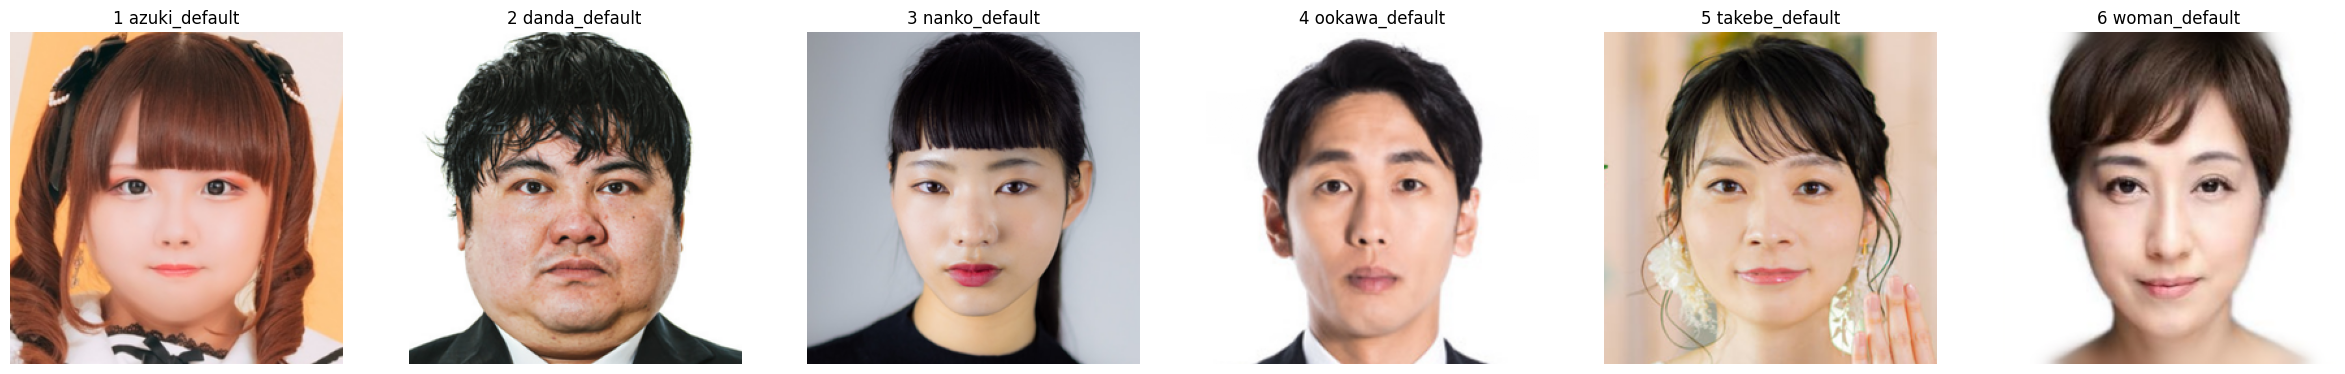

In [13]:
import matplotlib.pyplot as plt

num_batch = len(batch)
fig, ax = plt.subplots(1, num_batch, figsize=(5*num_batch, 5))
for i in range(num_batch):
    ax[i].imshow(batch[i].permute([1, 2, 0]) / 2 + 0.5)
    ax[i].set_title(f"{i+1} {names_batch[i]}")
    ax[i].axis('off')

In [14]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

In [15]:
print(CelebAttrDataset.id_to_cls)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [37]:
cls_name = 'Smiling'
cls_id = CelebAttrDataset.cls_to_id[cls_name]
cls_name = cls_name.lower()

In [18]:
preds = []
alpha = torch.tensor(np.linspace(-0.5, 0.5, 11, dtype=np.float32)).to(device)
cond_norm = cls_model.normalize(cond)
cond_cls = F.normalize(cls_model.classifier.weight[cls_id][None, :], dim=1)
for i, alp in enumerate(alpha):
    cond2 = cond_norm + alp * math.sqrt(512) * cond_cls
    cond2 = cls_model.denormalize(cond2)
    pred = model.render(xT, cond2, T=100)
    preds.append(pred)

In [19]:
preds = torch.stack(preds)
preds = preds.permute(1,0,2,3,4)

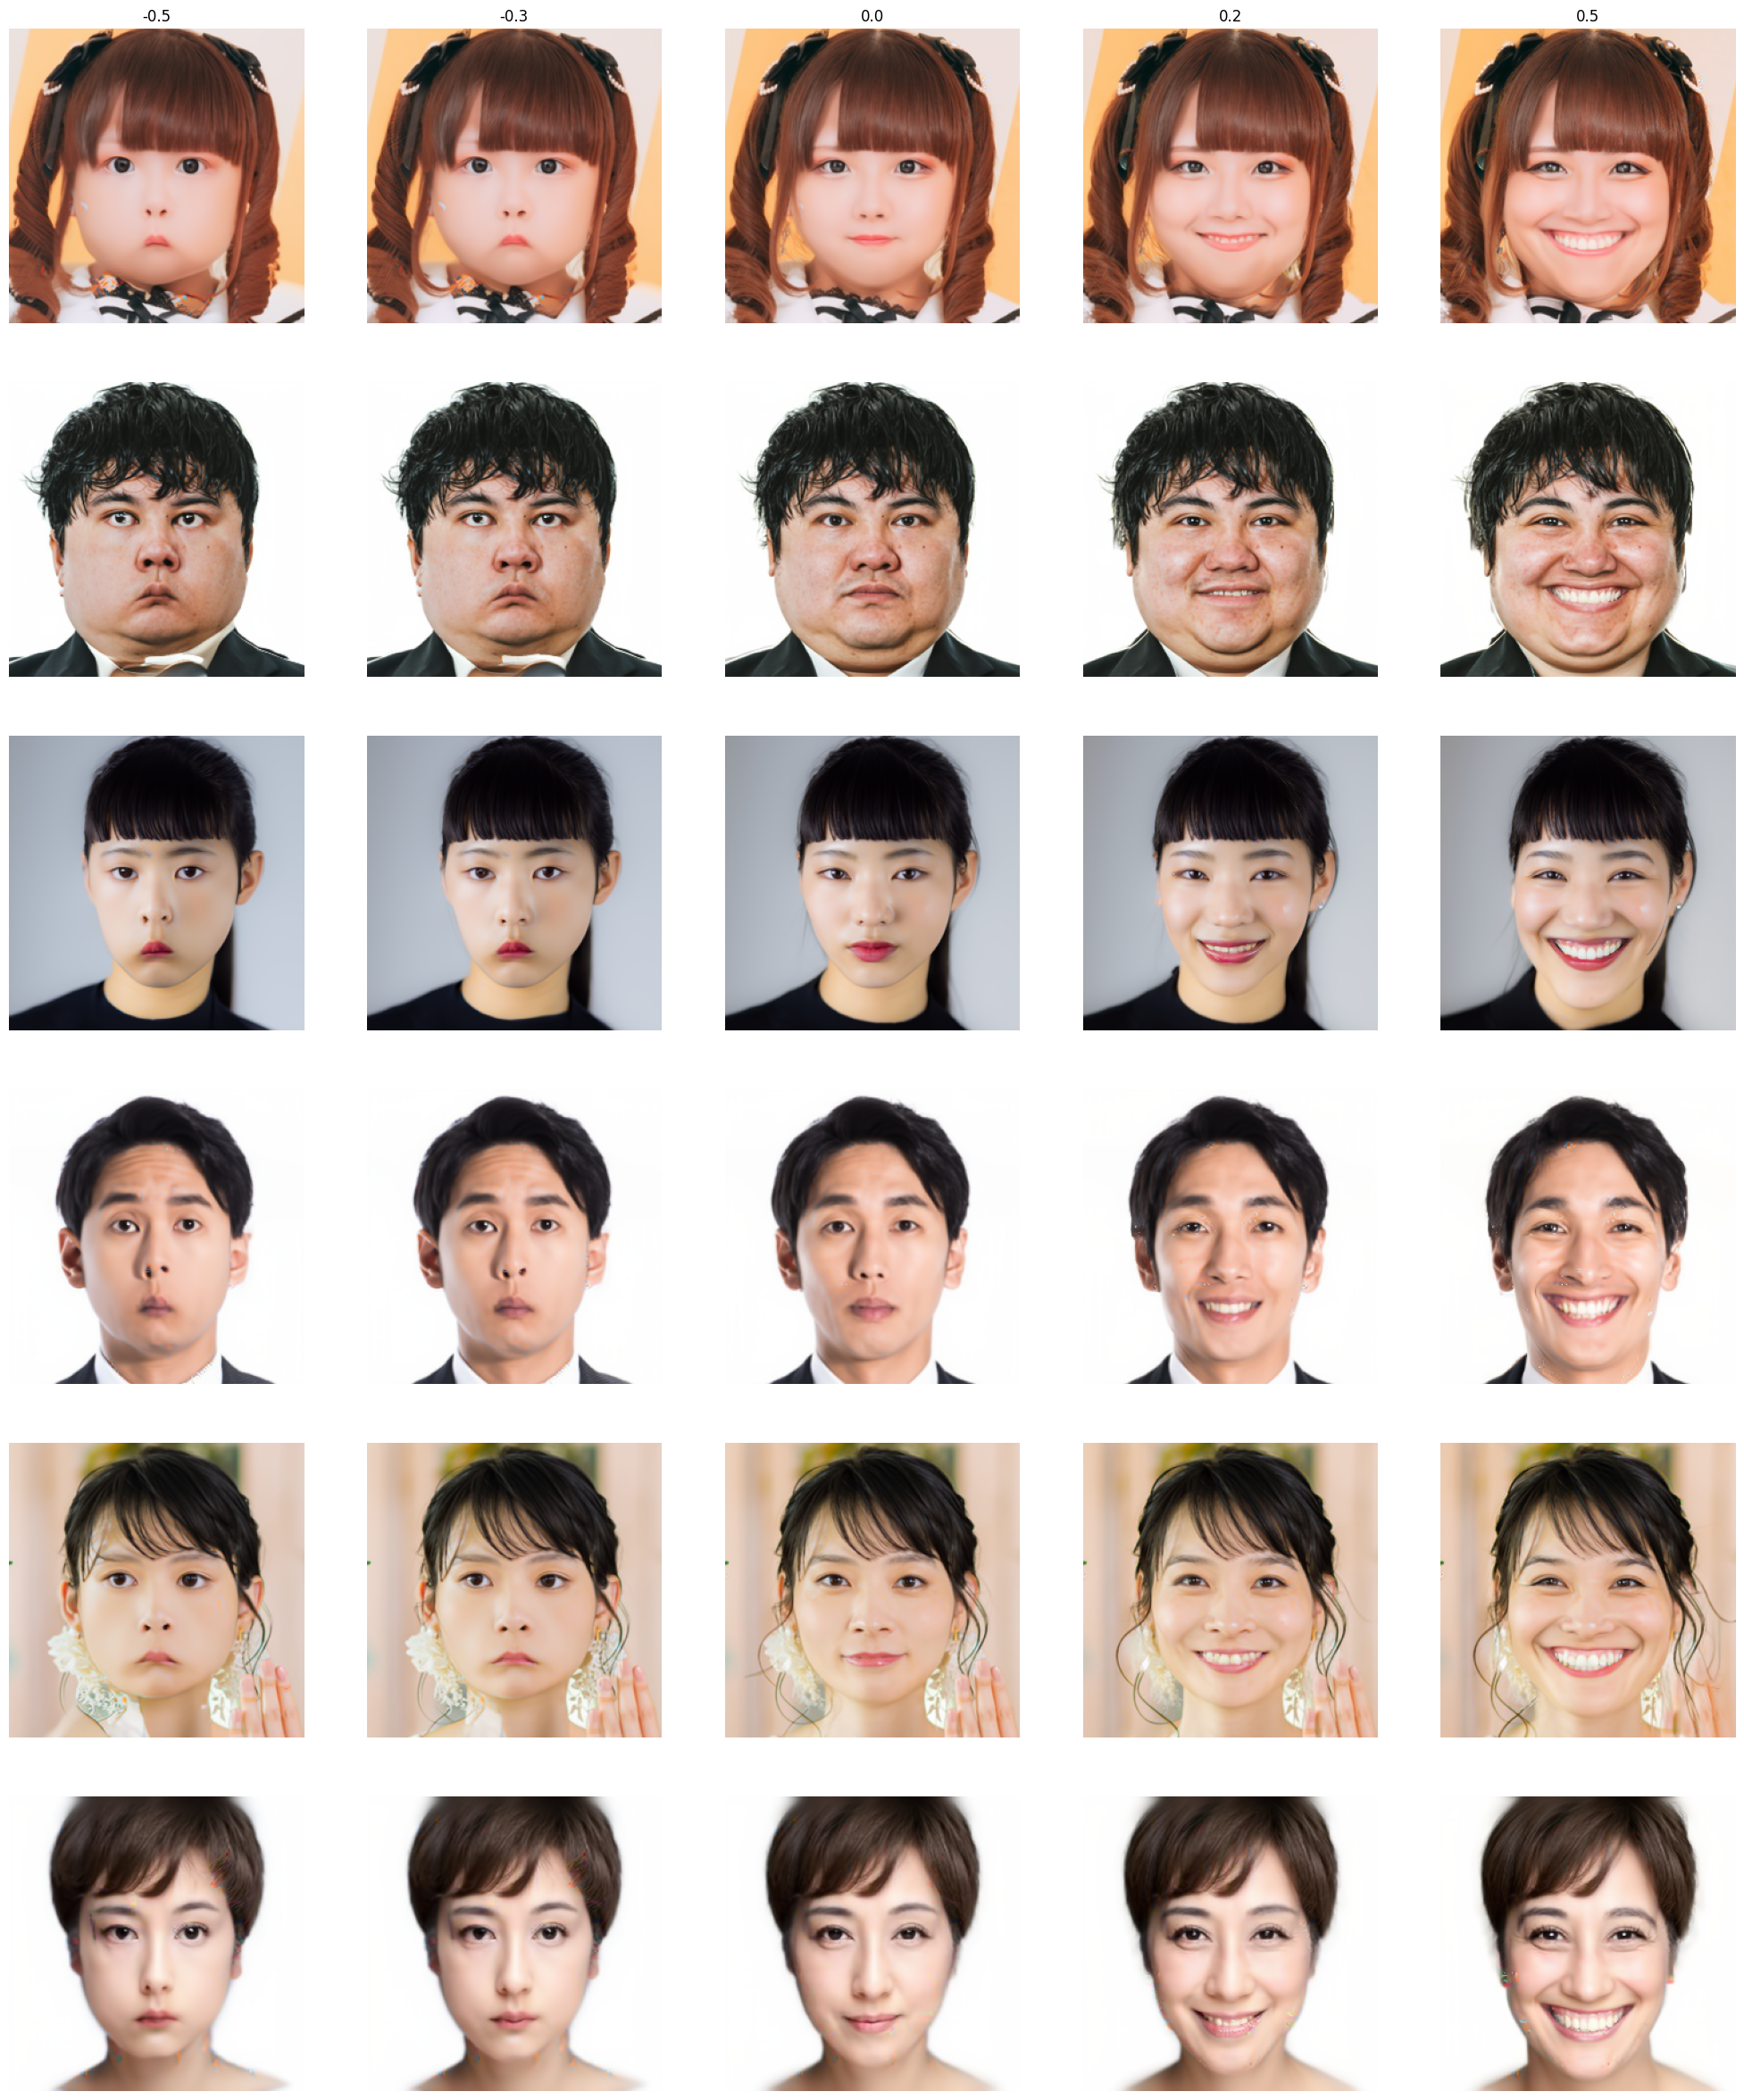

In [27]:
import matplotlib.pyplot as plt

num_show = 5
fig,ax = plt.subplots(num_batch, num_show, figsize=(5*num_show, 5*num_batch))
for i,pred in enumerate(preds):
    for j,k in enumerate(np.linspace(0,len(pred)-1,num_show,dtype=np.uint8)):
        ax[i,j].imshow(pred[k].permute(1,2,0).cpu())
        if i == 0:
            ax[i,j].set_title(np.array(alpha[k].cpu()))
        ax[i,j].axis('off')

In [28]:
from PIL import Image

preds_pil = []
for pred in preds:
    pred_pil = []
    for p in pred:
        p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
        pred_pil.append(Image.fromarray(p_np))
    preds_pil.append(pred_pil)

## gifの保存

### 名前自動（まとめて）

In [42]:
dst_dir = "imgs_test/imgs_manipulate/"
for i,pred_pil in enumerate(preds_pil):
    frs_dir = f"{dst_dir}{names_batch[i]}2{cls_name}/"
    if not os.path.exists(frs_dir): os.makedirs(frs_dir)
    file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}-{np.array(alpha.detach().cpu())[-1]:.2f}-{len(alpha)}.gif"
    dst_path = frs_dir + file_name

    pred_pil[0].save(
        dst_path,
        format="gif",
        save_all=True,
        append_images=pred_pil,
        duration=120//(len(alpha)-1),
        loop=0,
    )

### 名前手動（ひとつずつ）

In [32]:
for i, name in enumerate(names_batch):
    print(f'{i:2}: {name}')

 0: azuki_default
 1: danda_default
 2: nanko_default
 3: ookawa_default
 4: takebe_default
 5: woman_default


In [82]:
index = 0
dst_dir = "imgs_test/imgs_manipulate/"
file_name = "yotaka2smile.gif"
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
dst_path = dst_dir + file_name

preds_pil[index][0].save(
    dst_path,
    format="gif",
    save_all=True,
    append_images=preds_pil[index],
    duration=120//(len(alpha)-1),
    loop=0,
)

## 静止画像（フレーム）の保存

### 名前自動（まとめて）

**※容量注意**

In [41]:
from torchvision.utils import save_image

dst_dir = "imgs_test/imgs_manipulate/"
for i,pred in enumerate(preds):
    frs_dir = f"{dst_dir}{names_batch[i]}2{cls_name}/"
    if not os.path.exists(frs_dir): os.makedirs(frs_dir)
    for j,p in enumerate(pred):
        file_name = f"{frs_dir}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
        save_image(p, file_name, format='PNG')

### 名前手動（ひとつずつ）

In [31]:
print('index: name')
for i, name in enumerate(names_batch):
    print(f'{i:5}: {name}')

index: name
    0: azuki_default
    1: danda_default
    2: nanko_default
    3: ookawa_default
    4: takebe_default
    5: woman_default


In [29]:
print('index: amplitude')
for i,a in enumerate(np.array(alpha.detach().cpu())):
    print(f'{i:5}: {a}')

index: amplitude
    0: -0.5
    1: -0.4000000059604645
    2: -0.30000001192092896
    3: -0.20000000298023224
    4: -0.10000000149011612
    5: 0.0
    6: 0.10000000149011612
    7: 0.20000000298023224
    8: 0.30000001192092896
    9: 0.4000000059604645
   10: 0.5


In [ ]:
index_name = 0
index_amp = 0
dst_dir = "imgs_test/imgs_manipulate/"
file_name = "yotaka2smile.png"
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
dst_path = dst_dir + file_name
save_image(preds[index_name][index_amp], dst_path)